# 프로젝트 평가 기준

### 1. AutoInt+ 모델을 구현하였습니다.
- 본 프로젝트에서는 AutoInt+ 모델을 직접 구현하였습니다.
- 모델은 Embedding → Multi-head Self-Attention → Residual Connection → MLP → Output Layer로 구성되어 있습니다.
- TensorFlow의 `tf.keras.layers.Layer`를 커스터마이징하여 작성하였습니다.
- 구현한 모델을 `compile()` 후 `fit()`을 통해 학습하였고, `evaluate()`를 사용하여 성능을 평가하였습니다.
- 학습이 완료된 모델의 가중치는 `.save_weights()`를 통해 저장하였습니다.

---

### 2. 구현한 추천 시스템을 시각화하였습니다.
- Streamlit을 활용하여 사용자 기반 추천 시스템을 시각화하였습니다.
- 사용자 ID를 선택하면 해당 사용자의 영화 시청 이력을 기반으로 추천 결과가 출력되며, 추천된 영화 목록이 화면에 정상적으로 표시됩니다.
- 추천 결과는 직관적으로 확인할 수 있도록 구성하였으며, 사용자의 선택에 따라 실시간으로 변화합니다.
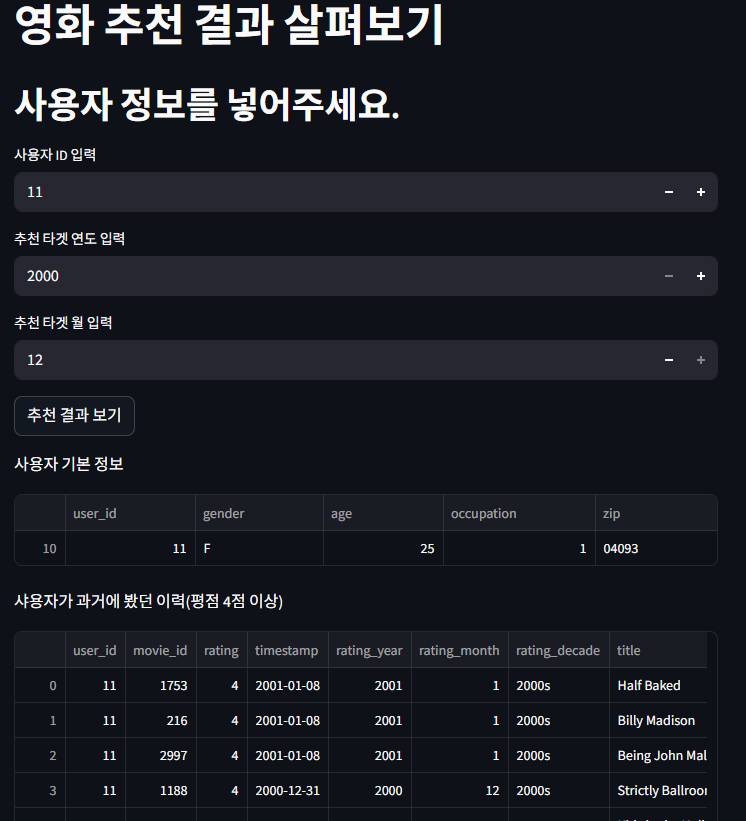

---

### 3. AutoInt+ 모델의 성능을 향상시키기 위한 다양한 시도를 수행하였습니다.
- 모델 성능 향상을 위해 하이퍼파라미터를 조정하며 총 3회의 실험을 수행하였습니다.
- 각 실험에서는 epoch, learning rate, dropout 비율, batch size, embedding 차원 수를 변경하며 성능 개선을 시도하였습니다.
- 실험 결과는 다음과 같습니다.

| 실험 번호 | epoch | learning rate | dropout | batch size | embedding dim | NDCG   | Hitrate |
|-----------|--------|----------------|---------|-------------|----------------|--------|---------|
| 기본값    | 5      | 1e-4           | 0.4     | 2048        | 16             | 0.6617 | 0.6298  |
| 실험 1    | 20     | 1e-4           | 0.4     | 2048        | 16             | 0.6618 | 0.6303  |
| 실험 2    | 20     | 1e-4           | 0.2     | 1024        | 32             | 0.6663 | 0.6325  |
| 실험 3    | 20     | 5e-4           | 0.2     | 1024        | 32             | 0.6667 | 0.6352  |

- **실험 1**에서는 epoch 수만 늘려 학습을 더 진행해보았고, 약간의 성능 향상이 있었습니다.
- **실험 2**에서는 dropout을 줄이고 embedding 크기를 늘려 성능 개선을 확인할 수 있었습니다.
- **실험 3**에서는 learning rate를 증가시켜 가장 높은 성능을 기록하였습니다.

---


# 프로젝트 목표 
- 영화 데이터 MovieLens 1M과 대표적인 딥러닝 기반 추천 시스템 모델인 AutoInt를 사용하여 영화 추천 시스템 만들기
- AutoInt 모델을 직접 구현해보고 최종적으로 스트림릿(Streamlit)을 활용해 시각화
- 참고
   - POC란 : 개념 증명 또는 개념 실증이라고 불리는 POC(Proof of Concept)는 기존 시장에 없었던 신기술을 도입하기 전에 이를 검증하기 위해 사용하는 과정을 의미

# 데이터 불러오기
- MovieLens1M라는 데이터 셋
- MovieLens1m 데이터 셋은 grouplens에서 받을 수 있다. 링크 : https://grouplens.org/datasets/movielens/1m/
- **연구 및 실습용으로만 사용할 수 있고 재배포하거나 상업적으로는 사용할 수 없음**

## 데이터 다운로드
grouplens서 제공해주는 다운로드 링크를 사용하면 바로 다운로드받을 수 있습니다.    
- 다운로드 링크 : https://files.grouplens.org/datasets/movielens/ml-1m.zip

## 데이터 살펴보기
- 분석을 위한 환경을 만들기 위해 plotly 라이브러리 설치하기
- 시각화를 위한 라이브러리로 marplotlib이나 seaborn 등과 마찬가지로 많이 사용하는 라이브러리
- 시각적 요소가 잘 보이는것도 장점이고 상호작용 (interacting)이 되는것이 큰 장점이다.

In [1]:
# plotly 라이브러리 설치
# !pip install plotly
# !pip install seaborn

In [2]:
# 라이브러리 불러오기 & 데이터 로드 세팅

# 라이브러리 호출
import re 
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
plt.rc('font', family='Malgun Gothic')

In [3]:
# 데이터를 불러와 README.txt에서 확인된 컬럼 정보를 지정하기
user_colums = ['user_id', 'gender', 'age', 'occupation', 'zip']
rating_columns = ['user_id', 'movie_id', 'rating', 'timestamp']
movie_columns = ['movie_id', 'title', 'genres']

In [4]:
# 가져올 데이터 경로 설정하기
data_path = './ml-1m'

In [5]:
# 데이터를 불러옵니다.
users = pd.read_csv(f'{data_path}/users.dat', sep='::', header=None, names=user_colums, engine='python')
ratings = pd.read_csv(f'{data_path}/ratings.dat', sep='::', header=None, names=rating_columns, engine='python')
movies = pd.read_csv(f'{data_path}/movies.dat', sep='::', header=None, names=movie_columns, engine='python', encoding='latin-1')

### 1. 데이터 users 정보 확인하기
**사용자의 정보는 `user_id`, `gender`, `age`, `occupation`, `zip` 정보로 구성됨**
- user_id : 1~6040 의 익명의 정보
- gender : M or F
- age : 18세 이하는 `1`/ 18 ~ 24세 `18`/ 25 ~ 34세 `25` 등으로 구성됨
- occupation : 2 → arist, 8 → farmer 등 숫자값으로 매핑

In [6]:
# 위 내용 직접 데이터 확인해보기
print(users.shape)
users.head()

(6040, 5)


,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


### 2. 데이터 ratings 정보 확인하기
**사용자 평점이 담겨 있는 데이터로 `user_id`, `movie_id`, `rating`, `timestamp` 정보로 구성**
- user_id : 1 ~ 6040 익명의정보
- movie_id : 1 ~ 3952 익명의 정보
- rating : 5점 평점
- timestamp : Unix timestamp
  > Unix timestamp란    
  > 1970년 1월 1일 00:00:00 UTC 이후 경과한 '초' 수를 말합니다. 우리가 흔히 알고 있는 연-월-일로 변환이 필요

In [7]:
# 위 내용 직접 데이터 확인해보기
print(ratings.shape)
ratings.head()

(1000209, 4)


,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


### 3. 데이터 movies 정보 확인하기
**영화 벙조가 담겨져 있는데이터로 `movie_id`, `title`, `genres` 정보로 구성**
- movie_id : 1 ~ 3952 익명의 정보
- title : 영화 제목과 연도
- genres : Action, Comedy 등 장르

In [8]:
# 위 내용 직접 데이터 확인해보기
print(movies.shape)
movies.head()

(3883, 3)


,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


## 데이터 분석
- 사전에 데이터를 파악하지 않고 모델을 구축하면 원하는 문제가 해결되지 않을 수 있어 데이터를 이해하는 것은 매우 중요하다.
- 데이터가 바라는 방향 분류, 점수 예측 등 그리고 특징 평향이 있는지 없는지 등을 파악하고 모델을 구성해야한다.
- 데이터 분석 항목
  - 장르별 영화 수
  - 연도별 영화 수
  - 평점 분포
  - 장르별 평점

### 1. 영화데이터 (movies)
- 위에서 살펴본 데이터 정보를 분리하여 연도별 분석, 장르별 분석을 할 수 있다.

In [9]:
# 정규 표현식을 이용해 영화의 제목과 연도를 분리하기
# 이 정규표현식은 '괄호 안에 있는 숫자 4개만 뽑아주세요.' 라는 의미이다.

movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')

In [10]:
movies.head()

,movie_id,title,genres,year
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


**장르를 분리할 수도 있다**
- genres 칼럼은 `|`를 기준으로 여러개의 장르가 들어가있어 `|`를 기준으로 분리할 수 있다.
- split. 함수를 이용하여 데이터를 나무면 리스트로 변환되고 이를 dataframe `explode`함수를 적용하여 펼칠 수 있다.

In [11]:
movies['genres_split'] = movies['genres'].apply(lambda x : x.split('|'))
movies_exploded = movies.explode('genres_split')
movies_exploded.head(10)

,movie_id,title,genres,year,genres_split
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,Animation
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,Children's
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,Adventure
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,Children's
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,Comedy
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,Romance
3,4,Waiting to Exhale (1995),Comedy|Drama,1995,Comedy
3,4,Waiting to Exhale (1995),Comedy|Drama,1995,Drama


#### **장르별 영화 개수** 분석해보기
- 히스토리그램 그리기
- X축은 genres_split 을 기준으로 잡으면 장르별 영화 개수 분포를 그릴 수 있다.
- Y축은 개수가 된다.

In [12]:
# nbformat 모듈 설치
#!pip install -U nbformat
#!pip install notebook ipywidgets
#!pip install ipython

In [13]:
# plotly
px.histogram(movies_exploded, 
             x='genres_split', 
             height=450, 
             title='장르별 영화 수').update_xaxes(categoryorder="total descending")

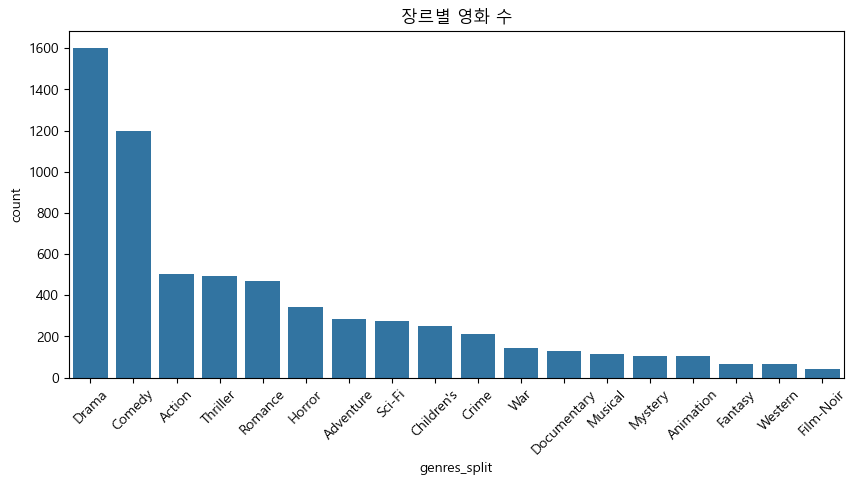

In [14]:
# seaborn 버전
sns.countplot(x='genres_split', data=movies_exploded, order = movies_exploded['genres_split'].value_counts().index)

plt.gcf().set_size_inches(10, 4.5)
plt.title('장르별 영화 수')
plt.xticks(rotation=45)
plt.show()

#### 연도별 영화 개수 살펴보기
- x축 : 연도
- y축 : 영화의 갯수
- 확인시 1995 ~ 2000년 사이의 영화가 가장 많다는걸 알 수 있다.

In [15]:
# plotly 버전 
movie_count_by_year = px.histogram(movies, 
                                   x='year', 
                                   height=450, 
                                   title='연도별 영화 수').update_xaxes(categoryorder="total descending")
movie_count_by_year

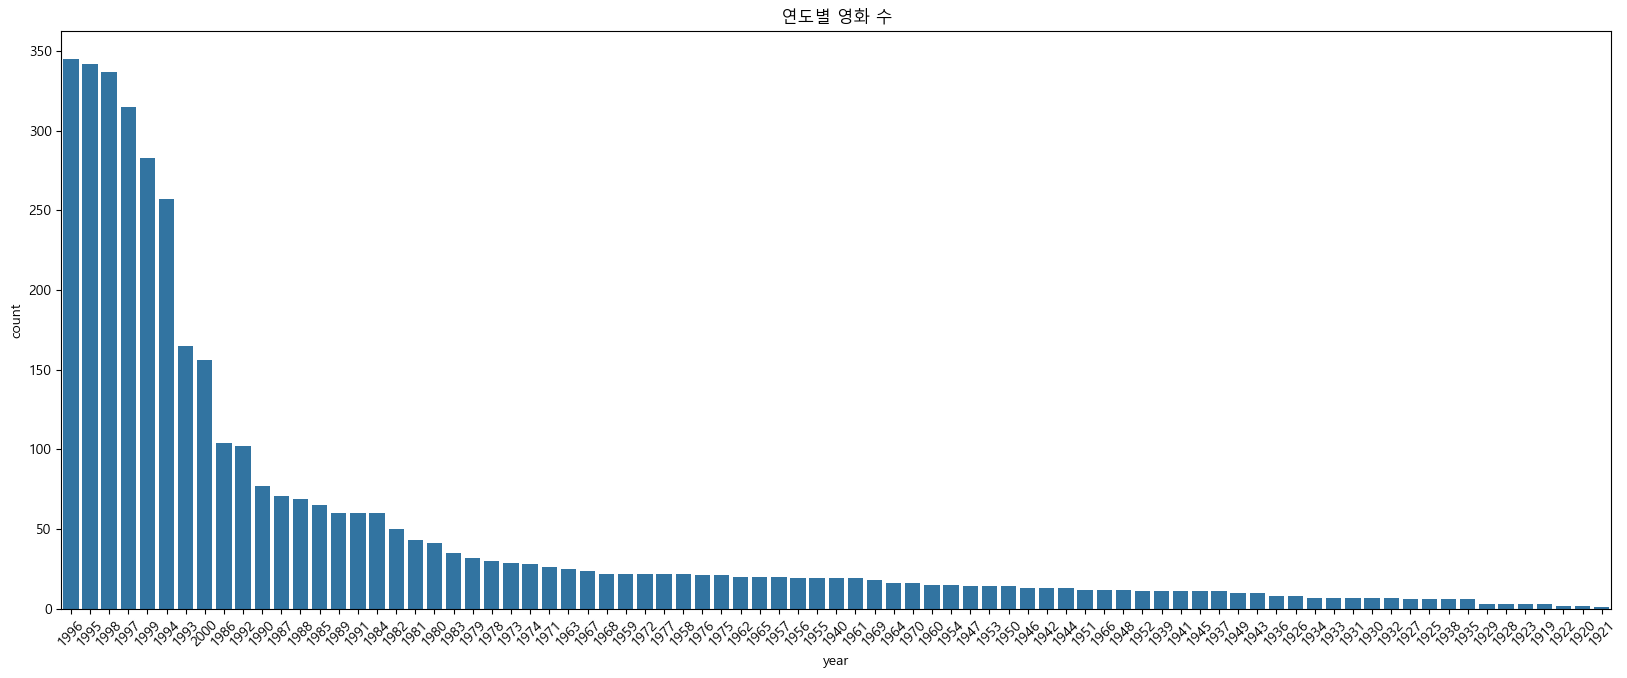

In [16]:
# seaborn 버전
year_counts = movies['year'].value_counts().reset_index()
year_counts.columns = ['year', 'count']

year_counts = year_counts.sort_values('count', ascending=False)

sns.barplot(x='year', y='count', data=year_counts)

plt.gcf().set_size_inches(20, 7.5)
plt.title('연도별 영화 수')
plt.xticks(rotation=45)
plt.show()

## 2. 평점 데이터(ratings)
평점 데이터로 영화를 분석해보기    
평점 데이터는 평균 평점이나 장르별 평점과 같이 다양한 관점으로 분석할 수 있다.

In [17]:
# 평점 데이터에서 movie_id를 기준으로 'groupby'를 사용하여 평점 평균 계산하기 
mv_rating_agg = pd.DataFrame(ratings.groupby('movie_id')['rating'].mean())
mv_rating_agg['num_of_ratings'] = pd.DataFrame(ratings.groupby('movie_id')['rating'].count())
mv_rating_agg = mv_rating_agg.reset_index()
mv_rating_agg.columns = ['movie_id', 'avg_rating', 'num_of_ratings']
mv_rating_agg

,movie_id,avg_rating,num_of_ratings
0,1,4.146846,2077
1,2,3.201141,701
2,3,3.016736,478
3,4,2.729412,170
4,5,3.006757,296
...,...,...,...
3701,3948,3.635731,862
3702,3949,4.115132,304
3703,3950,3.666667,54
3704,3951,3.900000,40


#### 평점 분포 
- 평균 평점별 영화 수를 히스토그램으로 그려보기
- x축 : 평균 평점
- y축 : 개수
- 확인시 정규분포는 아니고, 1점과 5점은 매우 적고 평점 3.5정도의 분포가 가장 많다.

In [18]:
# plotly 버전
px.histogram(mv_rating_agg, x='avg_rating', height=450, title='평점 분포')

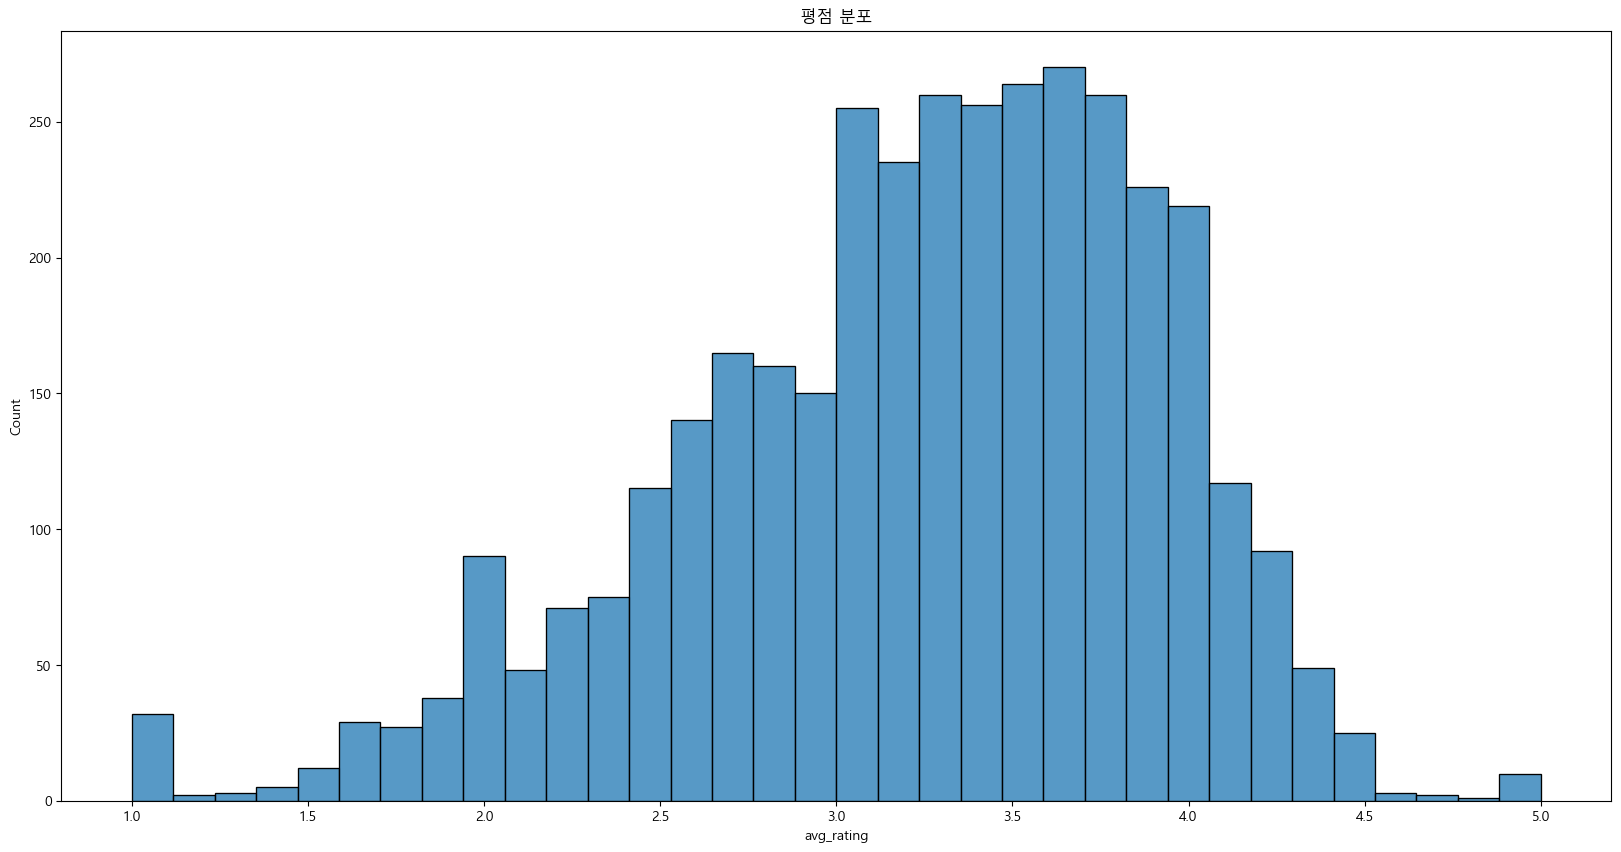

In [19]:
# seaborn 버전 
sns.histplot(mv_rating_agg['avg_rating'], kde=False)
plt.gcf().set_size_inches(20, 10)
plt.title('평점 분포')
plt.show()

### 3. 장르별 평점 분포
장르를 기준으로 평점 분석을 해보기
- 장르를 genres_split으로 나누었었는데 이 데이터를 활용해 장르 분포를 살펴볼것
- 하나의 영화에는 1개 이상의 장르가 연결되어있기 때문

In [20]:
movies_exploded.head()

,movie_id,title,genres,year,genres_split
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,Animation
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,Children's
0,1,Toy Story (1995),Animation|Children's|Comedy,1995,Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,Adventure
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995,Children's


장르별 평점 분포를 알기위해 아래의 순서처럼 데이터를 만들어보기
1. 영화 평점 데이터와 영화 데이터를 합쳐준다.
2. genre_split를 기준으로 groupby한다.
3. groupby할 때 rating을 기준으로 평균(mean)과 개수(count)를 뽑아낸다.
4. rating과 mean을 기준으로 정렬한다.

In [21]:
rating_by_genre_df = pd.merge(ratings[['movie_id', 'rating']],
                              movies_exploded[['movie_id', 'genres_split']],
                              on='movie_id').groupby('genres_split').agg({'rating': ['mean', 'count']}).sort_values(('rating', 'mean')).reset_index()
rating_by_genre_df

genres_split    rating        
                     mean   count
0        Horror  3.215013   76386
1    Children's  3.422035   72186
2       Fantasy  3.447371   36301
3        Sci-Fi  3.466521  157294
4     Adventure  3.477257  133953
5        Action  3.491185  257457
6        Comedy  3.522099  356580
7      Thriller  3.570466  189680
8       Romance  3.607465  147523
9       Western  3.637770   20683
10      Musical  3.665519   41533
11      Mystery  3.668102   40178
12    Animation  3.684868   43293
13        Crime  3.708679   79541
14        Drama  3.766332  354529
15          War  3.893327   68527
16  Documentary  3.933123    7910
17    Film-Noir  4.075188   18261

In [22]:
# 컬럼 확인해보기
rating_by_genre_df.columns

MultiIndex([('genres_split',      ''),
            (      'rating',  'mean'),
            (      'rating', 'count')],
           )

In [23]:
# 칼럼을 익숙한 형태인 데이터프레임의 인덱스를 1개로 바꿔주기
# 아래의 과정은 col[0]의 값이 rating이면 _ 를 기준으로 데이터를 묶어달라는 의미를 가짐
for col in rating_by_genre_df.columns.values:
    if col[0] == 'rating':
        print('_'.join(col).strip())
    else:
        print(col[0])

genres_split
rating_mean
rating_count


In [24]:
# 컬럼을 직관적으로 변경하기
rating_by_genre_df.columns = ['_'.join(col).strip() if col[1] != '' else col[0] for col in rating_by_genre_df.columns.values]    
rating_by_genre_df

,genres_split,rating_mean,rating_count
0,Horror,3.215013,76386
1,Children's,3.422035,72186
2,Fantasy,3.447371,36301
3,Sci-Fi,3.466521,157294
4,Adventure,3.477257,133953
5,Action,3.491185,257457
6,Comedy,3.522099,356580
7,Thriller,3.570466,189680
8,Romance,3.607465,147523
9,Western,3.637770,20683


In [25]:
# 장르별 평점을 시각화해서 살펴보기 x축 : 장르 , y축 : 평균 평점

# plotly 버전
px.bar(rating_by_genre_df, x='genres_split', y='rating_mean', height=350, title='장르별 평점').update_xaxes(categoryorder="total descending")

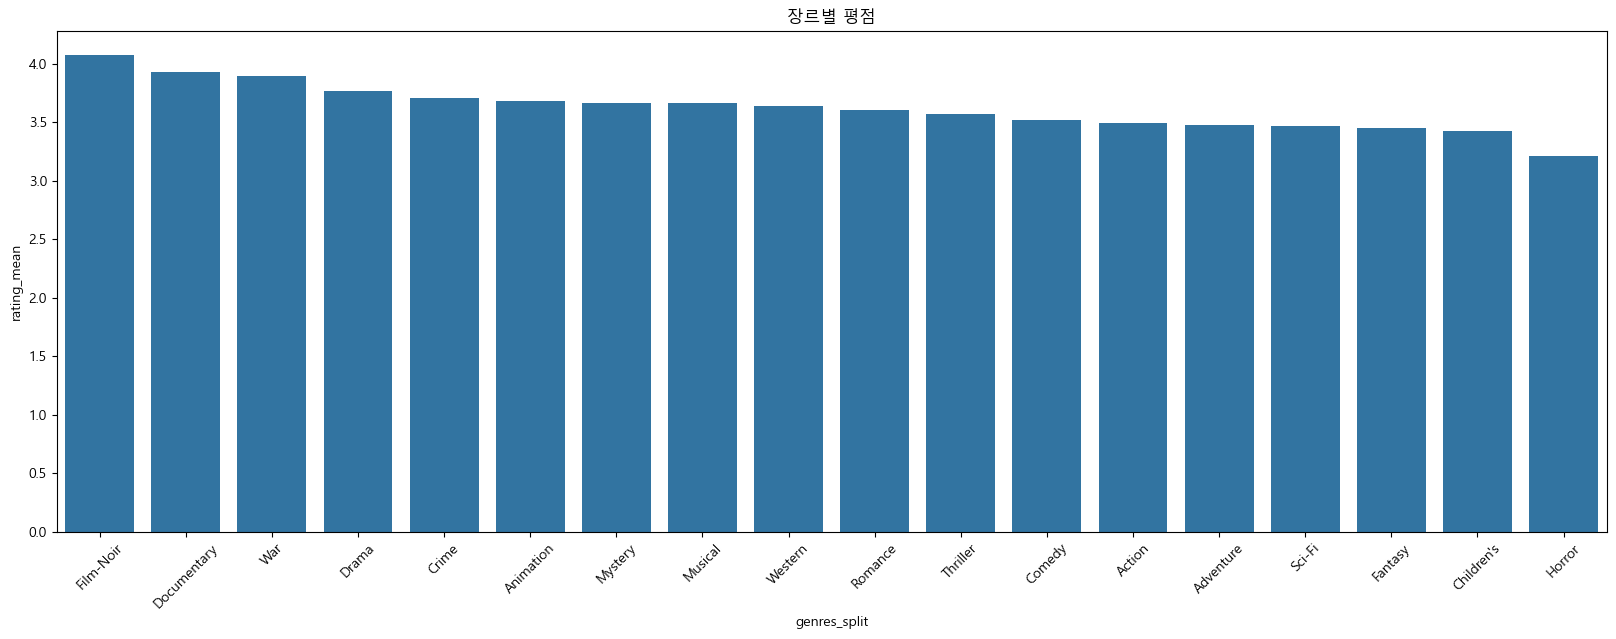

In [26]:
# seaborn 버전
rating_by_genre_df_sorted_by_mean = rating_by_genre_df.sort_values('rating_mean', ascending=False)

plt.figure(figsize=(20, 6.5))
sns.barplot(x='genres_split', y='rating_mean', data=rating_by_genre_df_sorted_by_mean)
plt.title('장르별 평점')
plt.xticks(rotation=45)
plt.show()

- 대부분 비슷한 평점을 가지고있지만 호러물은 상대적으로 낮은 평점을 가지고있다.
- 다큐멘터리가 높은 평점을 가지고있는데 장르별 평가 개수로 신뢰할 수 있는 값인지 확인해 보기
- x축: 장르
- y축: 평가 개수
- 확인시 평가 개수가 얼마 없어 편향되어있는 데이터라고 생각 할 수 있다. ( 확실한 취향이 있을 수 있음 )

In [27]:
# plotly 버전
px.bar(rating_by_genre_df, 
       x='genres_split', 
       y='rating_count', 
       height=350, 
       title='장르별 평가 개수').update_xaxes(categoryorder="total descending")

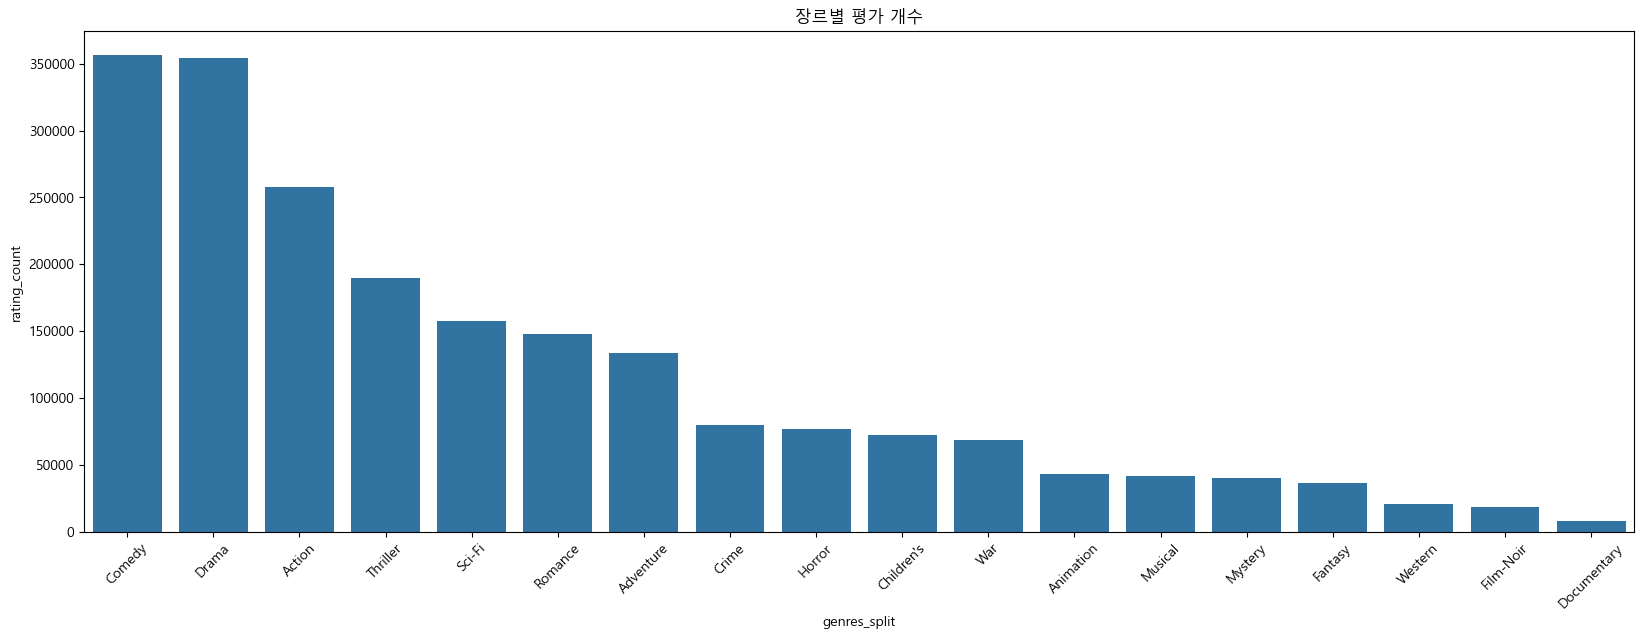

In [28]:
# seaborn 버전
rating_by_genre_df_sorted_by_count = rating_by_genre_df.sort_values('rating_count', ascending=False)

plt.figure(figsize=(20, 6.5))
sns.barplot(x='genres_split', y='rating_count', data=rating_by_genre_df_sorted_by_count)
plt.title('장르별 평가 개수')
plt.xticks(rotation=45)
plt.show()

### 데이터 분석 마무리
- 실제 모델 훈련에 사용할 수 있도록 데이터를 전처리해보고 훈련용 데이터를 만들기
- 사용자 데이터(users)와 사용자가 가지고 있는 직업(occupation)을 매핑해서 데이터를 깊게 살펴보기 위해 아래의 코드를 참고하기

In [29]:
# Occupation
occupation_map = {
    0:"other or not specified",
    1:"academic/educator",
    2:"artist",
    3:"clerical/admin",
    4:"college/grad student",
    5:"customer service",
    6:"doctor/health care",
    7:"executive/managerial",
    8:"farmer",
    9:"homemaker",
    10:"K-12 student",
    11:"lawyer",
    12:"programmer",
    13:"retired",
    14:"sales/marketing",
    15:"scientist",
    16:"self-employed",
    17:"technician/engineer",
    18:"tradesman/craftsman",
    19:"unemployed",
    20:"writer"
}

In [30]:
users['occupation_nm'] = users['occupation'].map(occupation_map)
users.head()

,user_id,gender,age,occupation,zip,occupation_nm
0,1,F,1,10,48067,K-12 student
1,2,M,56,16,70072,self-employed
2,3,M,25,15,55117,scientist
3,4,M,45,7,02460,executive/managerial
4,5,M,25,20,55455,writer


# 데이터 전처리
- 데이터를 전처리하고 훈련용 데이터를 세팅하는 과정을 정리해보기
- 원본 데이터를 그대로 모델에 사용하는건 좋은 성능을 끌어내기 힘듬
- 추천 시스템은 사용자와 아이템 사이의 상호작용을 모델링하기 때문에 데이터 설계에따라 사용자와 아이템의 상호작용이 불가능 할 수 있음
- 이번 모델에서는 아래의 피처들에 대해 상호작용 모델링을 할 예정
  - 사용자 : 사용자 ID, 성별, 나이, 지역, 직업
  - 영화 : 영화 ID, 장르, 시기
  - 평점 : 사용자 ID, 영화 ID, 평점, 시기    
- 즉 `어떤 사용자가 어떤 영화를 언제, 몇 점의 평가를 주었다`는 상호작용 데이터를 활용할 것

In [31]:
# 데이터를 불러와 확인하기, 라이브러리 호출  
import re 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import random
plt.rc('font', family='Malgun Gothic')

In [32]:
# 컬럼 정보 지정
user_colums = ['user_id', 'gender', 'age', 'occupation', 'zip']
rating_columns = ['user_id', 'movie_id', 'rating', 'timestamp']
movie_columns = ['movie_id', 'title', 'genres']

In [33]:
# 데이터 불러오기 
users = pd.read_csv(f'{data_path}/users.dat', sep='::', header=None, names=user_colums, engine='python')
ratings = pd.read_csv(f'{data_path}/ratings.dat', sep='::', header=None, names=rating_columns, engine='python')
movies = pd.read_csv(f'{data_path}/movies.dat', sep='::', header=None, names=movie_columns, engine='python', encoding='latin-1')

In [34]:
# 사용자 데이터 확인
print(users.shape)
users.head()

(6040, 5)


,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [35]:
# 영화 데이터 확인
print(movies.shape)
movies.head()

(3883, 3)


,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [36]:
# 평점 데이터 확인
print(ratings.shape)
ratings.head()

(1000209, 4)


,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 영화 데이터 전처리
- 영화 제목과 연도를 분리하는 과정만 진행했기 떄문에 한 가지의 데이터를 더 추출
- `년대`를 추출하기 1995년 → 90년대
- 영화나 음악의경우 90년대 음악, 영화 이런식으로 표현하기 때문
  1. 제목에서 영화의 연도를 뽑아낸다.
  2. 연도에서 연도를 10으로 나눈 나머지를 빼면 년대이다.

In [37]:
# 제목 뒤에 붙어 있는 연도를 정규표현식을 활용해 추출합니다. 
movies['movie_year'] = movies['title'].str.extract(r'\((\d{4})\)')
movies.head()

,movie_id,title,genres,movie_year
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [38]:
# 년대 구하기
a = 1995 % 10
b = 1995 - a

print(a)
print(b)

5
1990


In [39]:
# 90년대 영화, 2000년대 영화 등과 같은 년대 정보를 추출합니다. 
movies['movie_decade'] = movies['title'].str.extract(r'\((\d{4})\)')[0].astype(int).apply(lambda x: str(x - (x % 10)) + 's')

# title 컬럼에서 연도 정보를 빼고 제목만 따로 추출합니다.
movies['title'] = movies['title'].apply(lambda x: re.sub(r'\s*\(\d{4}\)', '', x))

In [40]:
movies.head()

,movie_id,title,genres,movie_year,movie_decade
0,1,Toy Story,Animation|Children's|Comedy,1995,1990s
1,2,Jumanji,Adventure|Children's|Fantasy,1995,1990s
2,3,Grumpier Old Men,Comedy|Romance,1995,1990s
3,4,Waiting to Exhale,Comedy|Drama,1995,1990s
4,5,Father of the Bride Part II,Comedy,1995,1990s


- 장르를 분리해서 추출
- 분리된 장르를 행에 추가했다면, 컬럼에 추가하기
- 나중에 모델 input에 넣을 때 편하게 사용할 수 있다.

In [41]:
# | 기호를 기준으로 장르 데이터를 분리합니다. 
genres_split = movies['genres'].str.split('|')

In [42]:
max_genres = genres_split.apply(len).max() 

# 각 장르별로 새로운 컬럼을 생성합니다.
for i in range(max_genres):
    movies[f'genre{i + 1}'] = genres_split.apply(lambda x: x[i] if i < len(x) else None)

# 원래 있던 장르 컬럼은 날려줍니다.
movies.drop('genres', axis=1, inplace=True)

# None은 공백으로 채웁니다.
movies.fillna('', inplace=True)

In [43]:
print(movies.shape)
movies.head()

(3883, 10)


,movie_id,title,movie_year,movie_decade,genre1,genre2,genre3,genre4,genre5,genre6
0,1,Toy Story,1995,1990s,Animation,Children's,Comedy,,,
1,2,Jumanji,1995,1990s,Adventure,Children's,Fantasy,,,
2,3,Grumpier Old Men,1995,1990s,Comedy,Romance,,,,
3,4,Waiting to Exhale,1995,1990s,Comedy,Drama,,,,
4,5,Father of the Bride Part II,1995,1990s,Comedy,,,,,


In [44]:
# 장르의 종류 확인하기
set(movies['genre1'].unique().tolist() + movies['genre2'].unique().tolist() + movies['genre3'].unique().tolist())

{'',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

## 평점 데이터 전처리
평점 데이터를 `timestmap`를 사용하여 쪼갤 수 있다.
- datetime의 fromtimestamp 함수를 사용하여 `년-월-일`로 변경하기

In [45]:
# fromtimestamp 활용해 변경해보기
timestamp = 978300760 
dt_object = datetime.fromtimestamp(timestamp)

print(dt_object.strftime("%Y-%m-%d"))

2001-01-01


In [46]:
# 평점 데이터 전체에 적용하기
ratings['timestamp'] = ratings['timestamp'].apply(lambda x : datetime.fromtimestamp(x).strftime("%Y-%m-%d"))
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,2001-01-01
1,1,661,3,2001-01-01
2,1,914,3,2001-01-01
3,1,3408,4,2001-01-01
4,1,2355,5,2001-01-07


In [47]:
# 변환된 `년-월-일` 데이터를 활용해 년도, 월, 년대를 뽑아내기
ratings['rating_year'] = ratings['timestamp'].apply(lambda x : x.split("-")[0]) 
ratings['rating_month'] = ratings['timestamp'].apply(lambda x : x.split("-")[1])
ratings['rating_decade'] = ratings['rating_year'].astype(int).apply(lambda x: str(x - (x % 10)) + 's')

In [48]:
# 확인
ratings.head()

,user_id,movie_id,rating,timestamp,rating_year,rating_month,rating_decade
0,1,1193,5,2001-01-01,2001,01,2000s
1,1,661,3,2001-01-01,2001,01,2000s
2,1,914,3,2001-01-01,2001,01,2000s
3,1,3408,4,2001-01-01,2001,01,2000s
4,1,2355,5,2001-01-07,2001,01,2000s


In [49]:
# 저장된 데이터를 _prepro 이름으로 csv형태로 임시저장하기
movies.to_csv(f"{data_path}/movies_prepro.csv", index=False)
ratings.to_csv(f"{data_path}/ratings_prepro.csv", index=False)
users.to_csv(f"{data_path}/users_prepro.csv", index=False)

## 모델 입력 데이터 생성
추천 시스템 활용 데이터
- 명시적 데이터(Explicit data): 사용자가 직접적으로 선호도를 표현한 데이터(예: 평점, 구독, 댓글, 리뷰, 좋아요, 싫어요, 차단 등)
- 암묵적 데이터(Implicit data): 사용자가 간접적으로 선호도를 표현한 데이터(예: 클릭 여부, 검색 기록, 방문 페이지, 마우스 움직임, 구매 내역, 시청 시간대 등)
    
명시적 데이터 1 ~ 5점과 같은 분포로 데이터가 존재 이것은 이진분류보다는 회귀 문제나 다중 분류 문제라고 할 수 있다.    
암묵적 데이터인 클릭의경우 클릭했다 안했다로 분리할 수 있고 클릭 했다는것은 `선호`한다 라는 의미도 담게되어 선호 정보를 모델링 한다고 볼 수 있다.    
    
이번 프로젝트에서는 '선호했다'를 기준으로 살펴볼 예정    
'선호했다'라는 정보는 무엇이고 '선호하지 않는다'라는 정보는 무엇일까?     
그리고 그런 데이터가 MovieLens에 있을지 문제를 풀어나가보자    

### 1. 랜덤 샘플링 기반 방법
데이터에서 '선호도'를 뽑아내기 위한 데이터로는 사용자가 영화에 평점을 매긴 데이터평점 데이터(ratings)가 있다.    
문제는 평점이 1부터 5점까지라서 '어떤 것을 선호한다'라고 말하기 어려움 여기서부터는 가설을 세우고 진행하는 것이 좋다.    
먼저 랜덤 샘플링 기반 방법으로 '선호', '비선호'를 추출한다.    
1. 선호 데이터를 추출한다.
  - 사용자가 3점 이상의 점수를 부여한 영화를 '선호'한다고 가정한다.
  - 이 데이터는 label=1인 값이다.
2. 비선호 데이터를 추출한다.
  - 사용자가 선호했던 영화 리스트를 추출한다
  - 전체 영화 중 사용자가 선호한다고 체크하지 않은 영화 리스트를 추출한다. 만약 전체 영화가 100개이고 사용자가 선호한다고 한 영화가 10개라면, 선호하지 않은 영화는 90개이다.
  - 영화 리스트 중 일부를 랜덤으로 샘플링한다. 이때 선호 영화 1개당 5개의 비선호 영화를 추출한다. 예를 들어 선호 영화가 10개라면 비선호 영화는 총 50개를 추출한다. 즉 비선호 영화 90개 중 50개를 추출하는 것이다.
  - 이 비선호 영화를 label=0으로 세팅한다.

In [50]:
# 1. 3점 이상의 점수를 부여한 영화를 '선호'영화라고 가정하고, 이를 label=1로 생성합니다.
ratings = ratings[ratings['rating'] >= 3]
ratings['label'] = 1
ratings.drop('rating', axis=1, inplace=True)
print(ratings.shape)
ratings.head()

(836478, 7)


,user_id,movie_id,timestamp,rating_year,rating_month,rating_decade,label
0,1,1193,2001-01-01,2001,01,2000s,1
1,1,661,2001-01-01,2001,01,2000s,1
2,1,914,2001-01-01,2001,01,2000s,1
3,1,3408,2001-01-01,2001,01,2000s,1
4,1,2355,2001-01-07,2001,01,2000s,1


In [51]:
# 1. 사용자가 봤던(선호했던) 영화 리스트를 추출합니다. 사용자마다 평점이 3점 이상인 영화 리스트가 구성됩니다. 
user_seen_movies = ratings.groupby('user_id')['movie_id'].apply(list).reset_index()
user_seen_movies.head()

,user_id,movie_id
0,1,"[1193, 661, 914, 3408, 2355, 1197, 1287, 2804,..."
1,2,"[1357, 3068, 1537, 647, 2194, 648, 2268, 2628,..."
2,3,"[3421, 648, 1394, 3534, 104, 2735, 1210, 1431,..."
3,4,"[3468, 1210, 2951, 1214, 1036, 260, 2028, 480,..."
4,5,"[2987, 2333, 1175, 39, 2337, 1535, 1392, 1466,..."


In [52]:
# 2. 먼저 고유 영화와 고유 사용자들을 가지고 옵니다. 
unique_movies = movies['movie_id'].unique()
unique_users = users['user_id'].unique()
negative_users = []
negative_movies = []
negative_labels = []

# 사용자별로 하나씩 진행합니다.
for user in unique_users:
    # 충분한 이력이 없는 사용자는 넘어갑니다. 충분한 이력이 없는 사용자 데이터는 훈련에 방해가 되고 overfitting 등이 될 수 있습니다.
    if len(user_seen_movies[user_seen_movies['user_id'] == user]) < 1:
        continue
    # 2-1. 해당 사용자가 선호하는 영화 리스트를 가지고 옵니다.
    user_seen_movie_list = user_seen_movies[user_seen_movies['user_id'] == user]['movie_id'].values[0]
    # 2-2. 전체 영화 중 사용자가 선호한 영화 정보를 제외합니다.
    user_non_seen_movie_list = list(set(unique_movies) - set(user_seen_movie_list))
    # 2-3. 선호 영화 1개당 비선호 영화 5개를 추출합니다. 
    sample_pop_size = len(user_seen_movie_list)*5
    # 만약 비선호 영화 샘플 개수가 전체 영화 개수보다 크면, 비선호 영화 샘플 개수는 전체 영화 개수에서 사용자가 선호한 영화의 개수를 뺀 값(해당 사용자 입장에선 샘플링 최대 값)으로 설정합니다.
    if len(unique_movies) - len(user_seen_movie_list) < len(user_seen_movie_list)*5 :
        sample_pop_size = len(unique_movies) - len(user_seen_movie_list)
    # 랜덤으로 추출합니다. 
    user_negative_movie_list = random.sample(user_non_seen_movie_list, sample_pop_size)
    
    # 해당 값들을 리스트에 저장합니다.
    negative_users += [user for _ in range(len(user_negative_movie_list))]
    negative_movies += user_negative_movie_list
    negative_labels += [0 for _ in range(len(user_negative_movie_list))]

위 처럼 만들어진 데이터는 사용자가 `비선호`한다는 정보를 담고 있다. 따라서, label도 0이다.    
이 데이터를 하나의 데이터프레임으로 만들고 사용자 선호 정보와 합치면 0과 1이 조합된 훈련 데이터가 만들어진다.

In [53]:
print(len(negative_users))
print(len(negative_movies))
print(len(negative_labels))

4068124
4068124
4068124


In [54]:
negative_ratings_df = pd.DataFrame({'user_id' : negative_users, 
                                    'movie_id' : negative_movies, 
                                    'label':negative_labels})
print(negative_ratings_df.shape)
negative_ratings_df.head()

(4068124, 3)


,user_id,movie_id,label
0,1,2075,0
1,1,3787,0
2,1,3192,0
3,1,971,0
4,1,1233,0


최종적으로 모델 훈련에 사용하는 데이터를 구성하기 위해서 필요한 컬럼만 추출해 활용
- 평점 : 사용자 ID, 영화 ID, 레이블(label)
- 영화 : 영화 ID, 년대, 년도, 장르1
- 사용자 : 사용자 ID, 성별, 나이, 지역, 직업

In [55]:
# 하나의 데이터로 합치기
ratings_df = ratings[['user_id', 'movie_id', 'label']] 
ratings_df = pd.concat([ratings_df, negative_ratings_df], axis=0)
movies_df = movies[['movie_id', 'movie_decade', 'movie_year', 'genre1']]
movies_df.columns = ['movie_id', 'decade', 'movie_year', 'genre']
user_df = users[['user_id', 'gender', 'age', 'occupation', 'zip']]

In [56]:
merge_mlens_data = pd.merge(ratings_df, movies_df, on='movie_id')
merge_mlens_data = pd.merge(merge_mlens_data, user_df, on='user_id')
merge_mlens_data.dropna(inplace=True)
print(merge_mlens_data.shape)
merge_mlens_data.head()

(4904602, 10)


,user_id,movie_id,label,decade,movie_year,genre,gender,age,occupation,zip
0,1,1193,1,1970s,1975,Drama,F,1,10,48067
1,1,661,1,1990s,1996,Animation,F,1,10,48067
2,1,914,1,1960s,1964,Musical,F,1,10,48067
3,1,3408,1,2000s,2000,Drama,F,1,10,48067
4,1,2355,1,1990s,1998,Animation,F,1,10,48067


In [57]:
merge_mlens_data = merge_mlens_data[['user_id', 'movie_id','decade', 'movie_year', 'genre', 'gender', 'age', 'occupation', 'zip', 'label']]
print(merge_mlens_data.shape)
merge_mlens_data.head()

(4904602, 10)


,user_id,movie_id,decade,movie_year,genre,gender,age,occupation,zip,label
0,1,1193,1970s,1975,Drama,F,1,10,48067,1
1,1,661,1990s,1996,Animation,F,1,10,48067,1
2,1,914,1960s,1964,Musical,F,1,10,48067,1
3,1,3408,2000s,2000,Drama,F,1,10,48067,1
4,1,2355,1990s,1998,Animation,F,1,10,48067,1


In [58]:
# 위 데이터를 movielens_rcmm_v1이라고 명명하고 csv 형식으로 저장
merge_mlens_data.to_csv(f'{data_path}/movielens_rcmm_v1.csv', index=False)

### 2. 선호도로 나누기
- 샘플링을 하지 않고 데이터를 선호도로 나누기 (이전 방법은 사용자 벙보를 무작위로 샘플링을해서 임의로 데이터를 생성해 좋은 방법은 아님)
- 이후 모델을 훈련할 때도 이 데이터를 활용

In [59]:
# 전처리 하고 저장했던 데이터 불러오기
users_df = pd.read_csv(f'{data_path}/users_prepro.csv')
ratings_df = pd.read_csv(f'{data_path}/ratings_prepro.csv')
movies_df = pd.read_csv(f'{data_path}/movies_prepro.csv')

In [60]:
print(users_df.columns)
print(ratings_df.columns)
print(movies_df.columns)

Index(['user_id', 'gender', 'age', 'occupation', 'zip'], dtype='object')
Index(['user_id', 'movie_id', 'rating', 'timestamp', 'rating_year',
       'rating_month', 'rating_decade'],
      dtype='object')
Index(['movie_id', 'title', 'movie_year', 'movie_decade', 'genre1', 'genre2',
       'genre3', 'genre4', 'genre5', 'genre6'],
      dtype='object')


**선호도 구성방법**
1. 평점이 4점 이상인 데이터를 label=1, 나머지를 label=0
2. 필요한 데이터만 추출하고 저장

In [61]:
# 1. 4점 이상인 데이터를 1로, 아닌 데이터를 0으로 설정합니다.  
ratings_df['label'] = ratings_df['rating'].apply(lambda x : x >=4).astype(int)

ratings_df = ratings_df[['user_id', 'movie_id', 'rating_year','rating_month', 'rating_decade', 'label']]
ratings_df.head()

,user_id,movie_id,rating_year,rating_month,rating_decade,label
0,1,1193,2001,1,2000s,1
1,1,661,2001,1,2000s,0
2,1,914,2001,1,2000s,0
3,1,3408,2001,1,2000s,1
4,1,2355,2001,1,2000s,1


In [62]:
# 2. 필요 데이터만 가지고 옵니다. 특히 장르는 3개만 가지고 와서 활용합니다.  
movies_df = movies_df[['movie_id', 'movie_decade', 'movie_year', 'genre1', 'genre2', 'genre3']]
users_df = users_df[['user_id', 'gender', 'age', 'occupation', 'zip']]

In [63]:
# 필요한 데이터를 합쳐줍니다.   
merge_mlens_data = pd.merge(ratings_df, movies_df, on='movie_id')
merge_mlens_data = pd.merge(merge_mlens_data, users_df, on='user_id')
merge_mlens_data.fillna('no', inplace=True)
print(merge_mlens_data.shape)
merge_mlens_data.head()

(1000209, 15)


,user_id,movie_id,rating_year,rating_month,rating_decade,label,movie_decade,movie_year,genre1,genre2,genre3,gender,age,occupation,zip
0,1,1193,2001,1,2000s,1,1970s,1975,Drama,no,no,F,1,10,48067
1,1,661,2001,1,2000s,0,1990s,1996,Animation,Children's,Musical,F,1,10,48067
2,1,914,2001,1,2000s,0,1960s,1964,Musical,Romance,no,F,1,10,48067
3,1,3408,2001,1,2000s,1,2000s,2000,Drama,no,no,F,1,10,48067
4,1,2355,2001,1,2000s,1,1990s,1998,Animation,Children's,Comedy,F,1,10,48067


In [64]:
merge_mlens_data = merge_mlens_data[['user_id', 
                                     'movie_id',
                                     'movie_decade', 
                                     'movie_year', 
                                     'rating_year', 
                                     'rating_month', 
                                     'rating_decade', 
                                     'genre1',
                                     'genre2', 
                                     'genre3', 
                                     'gender', 
                                     'age', 
                                     'occupation', 
                                     'zip', 
                                     'label']]
print(merge_mlens_data.shape)
merge_mlens_data.head()

(1000209, 15)


,user_id,movie_id,movie_decade,movie_year,rating_year,rating_month,rating_decade,genre1,genre2,genre3,gender,age,occupation,zip,label
0,1,1193,1970s,1975,2001,1,2000s,Drama,no,no,F,1,10,48067,1
1,1,661,1990s,1996,2001,1,2000s,Animation,Children's,Musical,F,1,10,48067,0
2,1,914,1960s,1964,2001,1,2000s,Musical,Romance,no,F,1,10,48067,0
3,1,3408,2000s,2000,2001,1,2000s,Drama,no,no,F,1,10,48067,1
4,1,2355,1990s,1998,2001,1,2000s,Animation,Children's,Comedy,F,1,10,48067,1


In [65]:
# 저장합니다.
merge_mlens_data.to_csv(f'{data_path}/movielens_rcmm_v2.csv', index=False)

# AutoInt 모델 구현 및 학습

## 추천 모델 학습
AutoInt 모델
- 멀티헤드 셀프 어텐션(multi-head self-attention)구조를 활용해 입력 피처들간의 상호작용과 관계성을 모델링
- 쌓아올린 구조(stack)를 통해 서로 다른 차원에서 피처 상호작용 학습
- 고차 상호작용을 명시적(explicitly) & 자동(automatic)으로 학습

위의 특징을 가지고 추천 모델을 구성함

[전체 아키텍처]
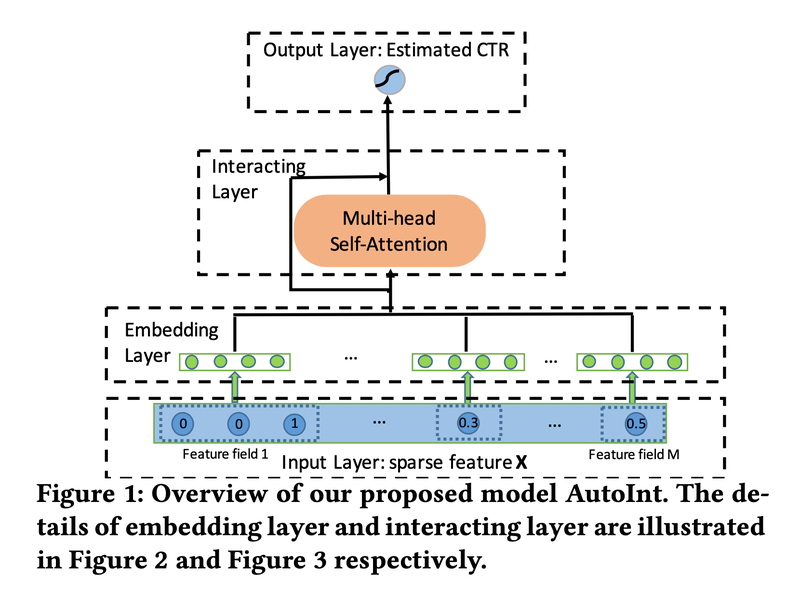
- 가장 중요한 부분은 바로 '멀티헤드 셀프어텐션 구조를 활용해서 피처간의 상호작용을 모델링한다' 이다.
- 이 모델의 코드를 이해할 때 해당 부분을 잘 이해하기만 한다면 코드 작업은 끝이라고 볼 수 있다.

# AutoInt+ 모델 시작
## 필요한 라이브러리 불러오기

In [66]:
import time
import random
import pandas as pd
import numpy as np
import os

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, MaxPooling2D, Conv2D, Dropout, Lambda, Dense, Flatten, Activation, Input, Embedding, BatchNormalization
from tensorflow.keras.initializers import glorot_normal, Zeros, TruncatedNormal
from tensorflow.keras.regularizers import l2


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy


from tensorflow.keras.optimizers import Adam
from collections import defaultdict
import math

In [67]:
# 임베딩 레이어

class FeaturesEmbedding(Layer):  
    '''
    임베딩 레이어입니다. 
    - 만약 피처(feature) 3개가 각각 10개, 20개, 30개의 고유값을 가진다면 feature_dims는 [10, 20, 30] 형태를 띄게 됩니다.
    - 전체 임베딩을 해야 할 개수는 10+20+30 = 60이므로 '60 x 임베딩_차원_크기'의 행렬이 생성되게 됩니다.
    '''
    def __init__(self, field_dims, embed_dim, **kwargs):
        super(FeaturesEmbedding, self).__init__(**kwargs)
        self.total_dim = sum(field_dims)
        self.embed_dim = embed_dim
        ## int 64로 바꿔주자
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.int32)
        self.embedding = tf.keras.layers.Embedding(input_dim=self.total_dim, output_dim=self.embed_dim)

    def build(self, input_shape):
        # 임베딩을 빌드하고 초기화합니다.
        self.embedding.build(input_shape)
        self.embedding.set_weights([tf.keras.initializers.GlorotUniform()(shape=self.embedding.weights[0].shape)])

    def call(self, x):
        # 들어온 입력의 임베딩을 가져니다.
        x = x + tf.constant(self.offsets)
        return self.embedding(x)

In [68]:
# DNN 레이어

class MultiLayerPerceptron(Layer):  
    '''
    DNN 레이어입니다.
    - Tensorflow Keras에서는 Dense 레이어를 쌓아올린 구조입니다.
    - 필요에 따라 배치 정규화도 사용할 수 있습니다.
    '''
    def __init__(self, input_dim, hidden_units, activation='relu', l2_reg=0, dropout_rate=0, use_bn=False, init_std=0.0001, output_layer=True):
        super(MultiLayerPerceptron, self).__init__()
        self.dropout_rate = dropout_rate
        self.use_bn = use_bn
        hidden_units = [input_dim] + list(hidden_units)
        if output_layer:
            hidden_units += [1]
        # Dense layer를 쌓아올립니다.
        self.linears = [Dense(units, activation=None, kernel_initializer=tf.random_normal_initializer(stddev=init_std),
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg)) for units in hidden_units[1:]]
        # 활성화 함수를 세팅합니다.
        self.activation = tf.keras.layers.Activation(activation)
        # 필요하다면 배치정규화도 진행합니다.
        if self.use_bn:
            self.bn = [BatchNormalization() for _ in hidden_units[1:]]
        self.dropout = Dropout(dropout_rate)

    def call(self, inputs, training=False):
        x = inputs
        for i in range(len(self.linears)):
            # input data가 들어오면 layer를 돌면서 벡터 값을 가져오게 됩니다.
            x = self.linears[i](x)
            if self.use_bn:
                x = self.bn[i](x, training=training)
            # 각 layer마다 나온 벡터 값에 활성화 함수와 dropout을 적용시켜 비선형성 구조와 과적합을 방지합니다.
            x = self.activation(x)
            x = self.dropout(x, training=training)
        return x

In [69]:
# 멀티 헤드 어텐션

class MultiHeadSelfAttention(Layer):  
    '''
    멀티 헤드 셀프 어텐션 레이어입니다.
    - 위에 작성한 수식과 같이 동작됩니다.
    - 필요에 따라 잔차 연결(residual connection)도 진행합니다.
    '''
    def __init__(self, att_embedding_size=8, head_num=2, use_res=True, scaling=False, seed=1024, **kwargs):
        if head_num <= 0:
            raise ValueError('head_num must be a int > 0')
        self.att_embedding_size = att_embedding_size
        self.head_num = head_num
        self.use_res = use_res
        self.seed = seed
        self.scaling = scaling
        super(MultiHeadSelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        if len(input_shape) != 3:
            raise ValueError(
                "Unexpected inputs dimensions %d, expect to be 3 dimensions" % (len(input_shape)))
        embedding_size = int(input_shape[-1])
        # 쿼리에 해당하는 매트릭스입니다. 
        self.W_Query = self.add_weight(name='query', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                       dtype=tf.float32,
                                       initializer=TruncatedNormal(seed=self.seed))
        # 키에 해당되는 매트릭스입니다.
        self.W_key = self.add_weight(name='key', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                     dtype=tf.float32,
                                     initializer=TruncatedNormal(seed=self.seed + 1))
        # 값(value)에 해당되는 매트릭스입니다.
        self.W_Value = self.add_weight(name='value', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                       dtype=tf.float32,
                                       initializer=TruncatedNormal(seed=self.seed + 2))
        # 필요하다면 잔차 연결도 할 수 있습니다.
        if self.use_res:
            self.W_Res = self.add_weight(name='res', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                         dtype=tf.float32,
                                         initializer=TruncatedNormal(seed=self.seed))

        super(MultiHeadSelfAttention, self).build(input_shape)

    def call(self, inputs, **kwargs):
        if K.ndim(inputs) != 3:
            raise ValueError("Unexpected inputs dimensions %d, expect to be 3 dimensions" % (K.ndim(inputs)))
        
        # 입력이 들어오면 쿼리, 키, 값(value)에 매칭되어 각각의 값을 가지고 옵니다.
        querys = tf.tensordot(inputs, self.W_Query, axes=(-1, 0))  
        keys = tf.tensordot(inputs, self.W_key, axes=(-1, 0))
        values = tf.tensordot(inputs, self.W_Value, axes=(-1, 0))

        # 헤드 개수에 따라 데이터를 분리해줍니다.
        querys = tf.stack(tf.split(querys, self.head_num, axis=2))
        keys = tf.stack(tf.split(keys, self.head_num, axis=2))
        values = tf.stack(tf.split(values, self.head_num, axis=2))
        
        # 쿼리와 키를 먼저 곱해줍니다. 위 이미지의 식 (5)와 같습니다.
        inner_product = tf.matmul(querys, keys, transpose_b=True)
        if self.scaling:
            inner_product /= self.att_embedding_size ** 0.5
        self.normalized_att_scores =  tf.nn.softmax(inner_product)
        
        # 쿼리와 키에서 나온 어텐션 값을 값(value)에 곱해줍니다. 식 (6)과 같습니다.
        result = tf.matmul(self.normalized_att_scores, values)
        # 식 (7)과 같이 쪼개어진 멀테 헤드를 모아줍니다.
        result = tf.concat(tf.split(result, self.head_num, ), axis=-1)
        result = tf.squeeze(result, axis=0) 

        if self.use_res:
            result += tf.tensordot(inputs, self.W_Res, axes=(-1, 0))
        result = tf.nn.relu(result)
        
        # 그 결과 값을 리턴합니다.

        return result

    def compute_output_shape(self, input_shape):

        return (None, input_shape[1], self.att_embedding_size * self.head_num)

    def get_config(self, ):
        config = {'att_embedding_size': self.att_embedding_size, 'head_num': self.head_num, 'use_res': self.use_res,'seed': self.seed}
        base_config = super(MultiHeadSelfAttention, self).get_config()
        base_config.update(config)
        return base_config

## AutoInt+ 모델

In [70]:
# 모델정의
class AutoIntMLP(Layer): 
    def __init__(self, field_dims, embedding_size, att_layer_num=3, att_head_num=2, att_res=True, dnn_hidden_units=(32, 32), dnn_activation='relu',
                 l2_reg_dnn=0, l2_reg_embedding=1e-5, dnn_use_bn=False, dnn_dropout=0.4, init_std=0.0001):
        super(AutoIntMLP, self).__init__()
        self.embedding = FeaturesEmbedding(field_dims, embedding_size)
        self.num_fields = len(field_dims)
        self.embedding_size = embedding_size

        self.final_layer = Dense(1, use_bias=False, kernel_initializer=tf.random_normal_initializer(stddev=init_std))
        
        self.dnn = tf.keras.Sequential()
        for units in dnn_hidden_units:
            self.dnn.add(Dense(units, activation=dnn_activation,
                               kernel_regularizer=tf.keras.regularizers.l2(l2_reg_dnn),
                               kernel_initializer=tf.random_normal_initializer(stddev=init_std)))
            if dnn_use_bn:
                self.dnn.add(BatchNormalization())
            self.dnn.add(Activation(dnn_activation))
            if dnn_dropout > 0:
                self.dnn.add(Dropout(dnn_dropout))
        self.dnn.add(Dense(1, kernel_initializer=tf.random_normal_initializer(stddev=init_std)))

        self.int_layers = [MultiHeadSelfAttention(att_embedding_size=embedding_size, head_num=att_head_num, use_res=att_res) for _ in range(att_layer_num)]

    def call(self, inputs):
        embed_x = self.embedding(inputs)
        dnn_embed = tf.reshape(embed_x, shape=(-1, self.embedding_size * self.num_fields))

        att_input = embed_x
        for layer in self.int_layers:
            att_input = layer(att_input)

        att_output = Flatten()(att_input)
        att_output = self.final_layer(att_output)
        
        dnn_output = self.dnn(dnn_embed)
        y_pred = tf.keras.activations.sigmoid(att_output + dnn_output)
        
        return y_pred

In [71]:
# 평가 지표
def get_DCG(ranklist, y_true):
    dcg = 0.0
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item in y_true:
            dcg += 1.0 / math.log(i + 2)
    return  dcg

def get_IDCG(ranklist, y_true):
    idcg = 0.0
    i = 0
    for item in y_true:
        if item in ranklist:
            idcg += 1.0 / math.log(i + 2)
            i += 1
    return idcg

def get_NDCG(ranklist, y_true):
    '''NDCG 평가 지표'''
    ranklist = np.array(ranklist).astype(int)
    y_true = np.array(y_true).astype(int)
    dcg = get_DCG(ranklist, y_true)
    idcg = get_IDCG(y_true, y_true)
    if idcg == 0:
        return 0
    return round( (dcg / idcg), 5)

def get_hit_rate(ranklist, y_true):
    '''hitrate 평가 지표'''
    c = 0
    for y in y_true:
        if y in ranklist:
            c += 1
    return round( c / len(y_true), 5 )

In [72]:
# 모델 테스트
def test_model(model, test_df):
    '''모델 테스트'''
    user_pred_info = defaultdict(list)
    total_rows = len(test_df)
    for i in range(0, total_rows, batch_size):
        features = test_df.iloc[i:i + batch_size, :-1].values
        y_pred = model.predict(features, verbose=False)
        for feature, p in zip(features, y_pred):
            u_i = feature[:2]
            user_pred_info[int(u_i[0])].append((int(u_i[1]), float(p)))
    return user_pred_info

## 학습용 데이터 만들기

In [73]:
project_path = os.path.abspath('./autoint')
data_dir_nm = 'data'
movielens_dir_nm = 'ml-1m'
model_dir_nm = 'model'
data_path = f"{project_path}/{data_dir_nm}"

In [74]:
# 1. 데이터 불러오기
# csv 데이터이므로 read_csv로 가져옵니다.
movielens_rcmm = pd.read_csv(f"{data_path}/movielens_rcmm_v2.csv", dtype=str)
print(movielens_rcmm.shape)
movielens_rcmm.head()

(1000209, 15)


,user_id,movie_id,movie_decade,movie_year,rating_year,rating_month,rating_decade,genre1,genre2,genre3,gender,age,occupation,zip,label
0,1,1193,1970s,1975,2001,1,2000s,Drama,no,no,F,1,10,48067,1
1,1,661,1990s,1996,2001,1,2000s,Animation,Children's,Musical,F,1,10,48067,0
2,1,914,1960s,1964,2001,1,2000s,Musical,Romance,no,F,1,10,48067,0
3,1,3408,2000s,2000,2001,1,2000s,Drama,no,no,F,1,10,48067,1
4,1,2355,1990s,1998,2001,1,2000s,Animation,Children's,Comedy,F,1,10,48067,1


In [75]:
# 2. 라벨 인코더(label encoder)
label_encoders = {col: LabelEncoder() for col in movielens_rcmm.columns[:-1]} # label은 제외

for col, le in label_encoders.items():
    movielens_rcmm[col] = le.fit_transform(movielens_rcmm[col])

In [76]:
movielens_rcmm.head()

,user_id,movie_id,movie_decade,movie_year,rating_year,rating_month,rating_decade,genre1,genre2,genre3,gender,age,occupation,zip,label
0,0,189,6,55,1,0,0,7,17,15,0,0,2,1588,1
1,0,3374,8,76,1,0,0,2,2,8,0,0,2,1588,0
2,0,3615,5,44,1,0,0,11,12,15,0,0,2,1588,0
3,0,2503,9,80,1,0,0,7,17,15,0,0,2,1588,1
4,0,1374,8,78,1,0,0,2,2,2,0,0,2,1588,1


In [77]:
movielens_rcmm['label'] = movielens_rcmm['label'].astype(np.float32)

In [78]:
# 3. 학습 데이터와 테스트데이터로 분리, 0.2 정도로 분리
train_df, test_df = train_test_split(movielens_rcmm, test_size=0.2, random_state=42)

In [79]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800167 entries, 416292 to 121958
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        800167 non-null  int32  
 1   movie_id       800167 non-null  int32  
 2   movie_decade   800167 non-null  int32  
 3   movie_year     800167 non-null  int32  
 4   rating_year    800167 non-null  int32  
 5   rating_month   800167 non-null  int32  
 6   rating_decade  800167 non-null  int32  
 7   genre1         800167 non-null  int32  
 8   genre2         800167 non-null  int32  
 9   genre3         800167 non-null  int32  
 10  gender         800167 non-null  int32  
 11  age            800167 non-null  int32  
 12  occupation     800167 non-null  int32  
 13  zip            800167 non-null  int32  
 14  label          800167 non-null  float32
dtypes: float32(1), int32(14)
memory usage: 51.9 MB


In [80]:
# 필요 컬럼들과 레이블 정의
# 필드의 각 고유 개수를 정의하는 field_dims를 정의합니다. 이는  임베딩 때 활용됩니다. 
u_i_feature = ['user_id', 'movie_id']

meta_features = ['movie_decade', 'movie_year', 'rating_year', 
                 'rating_month', 'rating_decade', 'genre1',
                 'genre2', 'genre3', 'gender', 
                 'age', 'occupation', 'zip']

label = 'label'
field_dims = np.max(movielens_rcmm[u_i_feature + meta_features].astype(np.int64).values, axis=0) + 1
field_dims

array([6040, 3706,   10,   81,    4,   12,    1,   18,   18,   16,    2,
          7,   21, 3439], dtype=int64)

# 훈련 환경 및 모델 세팅

In [81]:
# 에포크, 학습률, 드롭아웃, 배치사이즈, 임베딩 크기 등 정의
epochs = 20
learning_rate = 0.0005
dropout = 0.3
batch_size = 1024
embed_dim = 32

In [82]:
# AutoIntMLP를 가져와주고 DNN 레이어가 붙은 파라미터를 추가
class AutoIntMLPModel(Model):
    def __init__(self, field_dims, embedding_size, att_layer_num=3, att_head_num=2,
                 att_res=True, dnn_hidden_units=(32, 32), dnn_activation='relu',
                 l2_reg_dnn=0, l2_reg_embedding=1e-5, dnn_use_bn=False,
                 dnn_dropout=0.4, init_std=0.0001):
        super(AutoIntMLPModel, self).__init__()
        self.autoInt_layer = AutoIntMLP(
            field_dims=field_dims,
            embedding_size=embedding_size,
            att_layer_num=att_layer_num,
            att_head_num=att_head_num,
            att_res=att_res,
            dnn_hidden_units=dnn_hidden_units,
            dnn_activation=dnn_activation,
            l2_reg_dnn=l2_reg_dnn,
            l2_reg_embedding=l2_reg_embedding,
            dnn_use_bn=dnn_use_bn,
            dnn_dropout=dnn_dropout,
            init_std=init_std
        )

    def call(self, inputs, training=False):
        return self.autoInt_layer(inputs, training=training)

In [83]:
# 모델 정의
autoIntMLP_model = AutoIntMLPModel(
    field_dims=field_dims,
    embedding_size=embed_dim,
    att_layer_num=3,
    att_head_num=2,
    att_res=True,
    dnn_hidden_units=(32, 32),               # 추가: DNN 은닉층 구조
    dnn_activation='relu',                   # 추가: 활성화 함수
    l2_reg_dnn=0,
    l2_reg_embedding=1e-5,
    dnn_use_bn=False,
    dnn_dropout=dropout,
    init_std=0.0001
)

In [84]:
# 옵티마이저, 오차함수 정의
optimizer = Adam(learning_rate=learning_rate)
loss_fn = BinaryCrossentropy(from_logits=False)

In [85]:
autoIntMLP_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['binary_crossentropy'])

In [86]:
history = autoIntMLP_model.fit(train_df[u_i_feature + meta_features], 
                               train_df[label], 
                               epochs=epochs, 
                               batch_size=batch_size, 
                               validation_split=0.1)

Epoch 1/20


704/704 [==============================] - 84s 112ms/step - loss: 0.5720 - binary_crossentropy: 0.5720 - val_loss: 0.5404 - val_binary_crossentropy: 0.5404
Epoch 2/20
704/704 [==============================] - 77s 110ms/step - loss: 0.5353 - binary_crossentropy: 0.5353 - val_loss: 0.5333 - val_binary_crossentropy: 0.5333
Epoch 3/20
704/704 [==============================] - 78s 110ms/step - loss: 0.5272 - binary_crossentropy: 0.5272 - val_loss: 0.5295 - val_binary_crossentropy: 0.5295
Epoch 4/20
704/704 [==============================] - 93s 133ms/step - loss: 0.5220 - binary_crossentropy: 0.5220 - val_loss: 0.5285 - val_binary_crossentropy: 0.5285
Epoch 5/20
704/704 [==============================] - 94s 133ms/step - loss: 0.5182 - binary_crossentropy: 0.5182 - val_loss: 0.5264 - val_binary_crossentropy: 0.5264
Epoch 6/20
704/704 [==============================] - 96s 136ms/step - loss: 0.5148 - binary_crossentropy: 0.5148 - val_loss: 0.5245 - val_binary_crossentropy: 0.5

In [87]:
# 사용자에게 예측된 정보를 저장하는 딕셔너리 
user_pred_info = {}

# top10개
top = 10

# 테스트 값을 가지고 옵니다. 
mymodel_user_pred_info = test_model(autoIntMLP_model, test_df)

# 사용자마다 돌면서 예측 데이터 중 가장 높은 top 10만 가져옵니다. 
for user, data_info in tqdm(mymodel_user_pred_info.items(), total=len(mymodel_user_pred_info), position=0, leave=True):
    ranklist = sorted(data_info, key=lambda s : s[1], reverse=True)[:top]
    ranklist = list(dict.fromkeys([r[0] for r in ranklist]))
    user_pred_info[str(user)] = ranklist
    
# 원본 테스트 데이터에서 label이 1인 사용자 별 영화 정보를 가져옵니다.
test_data = test_df[test_df['label']==1].groupby('user_id')['movie_id'].apply(list)

C:\Users\nini\AppData\Local\Temp\ipykernel_6980\1878987022.py:11: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

100%|██████████| 6038/6038 [00:00<00:00, 80489.22it/s]


In [88]:
mymodel_ndcg_result = {}
mymodel_hitrate_result = {}

# 모델 예측값과 원본 테스트 데이터를 비교해서 어느정도 성능이 나왔는지 NDCG와 Hitrate를 비교합니다.

# NDCG
for user, data_info in tqdm(test_data.items(), total=len(test_data), position=0, leave=True):
    mymodel_pred = user_pred_info.get(str(user))

    testset = list(set(np.array(data_info).astype(int)))
    mymodel_pred = mymodel_pred[:top]

    # NDCG 값 구하기
    user_ndcg = get_NDCG(mymodel_pred, testset)

    mymodel_ndcg_result[user] = user_ndcg

# Hitrate
for user, data_info in tqdm(test_data.items(), total=len(test_data), position=0, leave=True):
    mymodel_pred = user_pred_info.get(str(user))

    testset = list(set(np.array(data_info).astype(int)))
    mymodel_pred = mymodel_pred[:top]

    # hitrate 값 구하기
    user_hitrate = get_hit_rate(mymodel_pred, testset)

    # 사용자 hitrate 결과 저장
    mymodel_hitrate_result[user] = user_hitrate

100%|██████████| 5994/5994 [00:00<00:00, 49526.14it/s]


In [89]:
print(" mymodel ndcg : ", round(np.mean(list(mymodel_ndcg_result.values())), 5))
print(" mymodel hitrate : ", round(np.mean(list(mymodel_hitrate_result.values())), 5))

 mymodel ndcg :  0.66799
 mymodel hitrate :  0.63645


In [91]:
# 모델의 가중치(weight)를 저장
autoIntMLP_model.save_weights('./autoint/model/autoIntMLP_model_weights.weights.h5')

C:\Users\nini\anaconda3\envs\py3_11\Lib\site-packages\keras\src\initializers\__init__.py:144: UserWarning:

The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'tensorflow.python.ops.init_ops_v2.RandomNormal'>, which may lead to improper serialization.



In [92]:
import joblib 

# 모델 객체를 pickled binary file 형태로 저장
joblib.dump(label_encoders, './autoint/data/autoIntMLP_label_encoders.pkl')

['./autoint/data/autoIntMLP_label_encoders.pkl']

노드 확인하기

### 모델 파일 autointmlp.py
`파이썬 파일 이름은 autointplus.py로 저장`

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, MaxPooling2D, Conv2D, Dropout, Lambda, Dense, Flatten, Activation, Input, Embedding, BatchNormalization
from tensorflow.keras.initializers import glorot_normal, Zeros, TruncatedNormal
from tensorflow.keras.regularizers import l2


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy


from tensorflow.keras.optimizers import Adam
from collections import defaultdict
import numpy as np
import tensorflow as tf
import math


class FeaturesEmbedding(Layer):
    def __init__(self, field_dims, embed_dim, **kwargs):
        super(FeaturesEmbedding, self).__init__(**kwargs)
        self.total_dim = sum(field_dims)
        self.embed_dim = embed_dim
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.longlong)
        self.embedding = tf.keras.layers.Embedding(input_dim=self.total_dim, output_dim=self.embed_dim)

    def build(self, input_shape):
        self.embedding.build(input_shape)
        self.embedding.set_weights([tf.keras.initializers.GlorotUniform()(shape=self.embedding.weights[0].shape)])

    def call(self, x):
        x = x + tf.constant(self.offsets)
        return self.embedding(x)

class MultiLayerPerceptron(Layer):
    def __init__(self, input_dim, hidden_units, activation='relu', l2_reg=0, dropout_rate=0, use_bn=False, init_std=0.0001, output_layer=True):
        super(MultiLayerPerceptron, self).__init__()
        self.dropout_rate = dropout_rate
        self.use_bn = use_bn
        hidden_units = [input_dim] + list(hidden_units)
        if output_layer:
            hidden_units += [1]

        self.linears = [Dense(units, activation=None, kernel_initializer=tf.random_normal_initializer(stddev=init_std),
                              kernel_regularizer=tf.keras.regularizers.l2(l2_reg)) for units in hidden_units[1:]]
        self.activation = tf.keras.layers.Activation(activation)
        if self.use_bn:
            self.bn = [BatchNormalization() for _ in hidden_units[1:]]
        self.dropout = Dropout(dropout_rate)

    def call(self, inputs, training=False):
        x = inputs
        for i in range(len(self.linears)):
            x = self.linears[i](x)
            if self.use_bn:
                x = self.bn[i](x, training=training)
            x = self.activation(x)
            x = self.dropout(x, training=training)
        return x

class MultiHeadSelfAttention(Layer):

    def __init__(self, att_embedding_size=8, head_num=2, use_res=True, scaling=False, seed=1024, **kwargs):
        if head_num <= 0:
            raise ValueError('head_num must be a int > 0')
        self.att_embedding_size = att_embedding_size
        self.head_num = head_num
        self.use_res = use_res
        self.seed = seed
        self.scaling = scaling
        super(MultiHeadSelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        if len(input_shape) != 3:
            raise ValueError(
                "Unexpected inputs dimensions %d, expect to be 3 dimensions" % (len(input_shape)))
        embedding_size = int(input_shape[-1])
        self.W_Query = self.add_weight(name='query', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                       dtype=tf.float32,
                                       initializer=TruncatedNormal(seed=self.seed))
        self.W_key = self.add_weight(name='key', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                     dtype=tf.float32,
                                     initializer=TruncatedNormal(seed=self.seed + 1))
        self.W_Value = self.add_weight(name='value', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                       dtype=tf.float32,
                                       initializer=TruncatedNormal(seed=self.seed + 2))
        if self.use_res:
            self.W_Res = self.add_weight(name='res', shape=[embedding_size, self.att_embedding_size * self.head_num],
                                         dtype=tf.float32,
                                         initializer=TruncatedNormal(seed=self.seed))

        super(MultiHeadSelfAttention, self).build(input_shape)

    def call(self, inputs, **kwargs):
        if K.ndim(inputs) != 3:
            raise ValueError(
                "Unexpected inputs dimensions %d, expect to be 3 dimensions" % (K.ndim(inputs)))

        querys = tf.tensordot(inputs, self.W_Query, axes=(-1, 0))
        keys = tf.tensordot(inputs, self.W_key, axes=(-1, 0))
        values = tf.tensordot(inputs, self.W_Value, axes=(-1, 0))

        querys = tf.stack(tf.split(querys, self.head_num, axis=2))
        keys = tf.stack(tf.split(keys, self.head_num, axis=2))
        values = tf.stack(tf.split(values, self.head_num, axis=2))

        inner_product = tf.matmul(querys, keys, transpose_b=True)
        if self.scaling:
            inner_product /= self.att_embedding_size ** 0.5
        self.normalized_att_scores =  tf.nn.softmax(inner_product)

        result = tf.matmul(self.normalized_att_scores, values)
        result = tf.concat(tf.split(result, self.head_num, ), axis=-1)
        result = tf.squeeze(result, axis=0) 

        if self.use_res:
            result += tf.tensordot(inputs, self.W_Res, axes=(-1, 0))
        result = tf.nn.relu(result)

        return result

    def compute_output_shape(self, input_shape):

        return (None, input_shape[1], self.att_embedding_size * self.head_num)

    def get_config(self, ):
        config = {'att_embedding_size': self.att_embedding_size, 'head_num': self.head_num
                  , 'use_res': self.use_res, 'seed': self.seed}
        base_config = super(MultiHeadSelfAttention, self).get_config()
        base_config.update(config)
        return base_config


class AutoInt(Layer):
    '''
    AutoInt 본체입니다. 앞서서 정의한 layer를 가져와서 계산을 수행합니다.
    '''
    def __init__(self, field_dims, embedding_size, att_layer_num=3, att_head_num=2, att_res=True, 
                 l2_reg_dnn=0, l2_reg_embedding=1e-5, dnn_use_bn=False, dnn_dropout=0.4, init_std=0.0001):
        super(AutoInt, self).__init__()
        # 임베딩 레이어를 정의합니다.
        self.embedding = FeaturesEmbedding(field_dims, embedding_size)
        self.num_fields = len(field_dims)
        self.embedding_size = embedding_size
        # 마지막 출력 레이어를 정의합니다.
        self.final_layer = Dense(1, use_bias=False, kernel_initializer=tf.random_normal_initializer(stddev=init_std))
        self.int_layers = [MultiHeadSelfAttention(att_embedding_size=embedding_size, head_num=att_head_num, use_res=att_res) for _ in range(att_layer_num)]

    def call(self, inputs):
        # input 데이터에 해당되는 embedding 값을 가져옵니다.
        att_input = self.embedding(inputs)
        # 멀티 헤드 셀프 어텐션 레이어에서 상호작용을 수행합니다.
        for layer in self.int_layers:
            att_input = layer(att_input)

        att_output = Flatten()(att_input)
        # 최종 출력 레이어
        att_output = self.final_layer(att_output)
        # sigmoid로 예측값 출력
        y_pred = tf.nn.sigmoid(att_output)

        return y_pred


# AutoInt 레이어를 가지고 있는 모델 본체입니다. 해당 모델을 활용해 훈련을 진행합니다.
class AutoIntModel(Model):
    def __init__(self, field_dims, embedding_size, att_layer_num=3, att_head_num=2
                 , att_res=True, l2_reg_dnn=0, l2_reg_embedding=1e-5, dnn_use_bn=False
                 , dnn_dropout=0, init_std=0.0001):
        super(AutoIntModel, self).__init__()
        self.autoInt_layer = AutoInt(field_dims, embedding_size, att_layer_num=att_layer_num, att_head_num=att_head_num, 
                                     att_res=att_res, l2_reg_dnn=l2_reg_dnn, dnn_dropout=dnn_dropout, init_std=init_std
                                    )

    def call(self, inputs, training=False):
        return self.autoInt_layer(inputs, training=training)

    
def predict_model(model, pred_df):
    '''
    모델 예측 함수. 모델과 예측하려는 데이터 프레임을 받아서 예측 수행
    '''
    batch_size = 2048
    top=10
    user_pred_info = []
    total_rows = len(pred_df)
    for i in range(0, total_rows, batch_size):
        features = pred_df.iloc[i:i + batch_size, :].values
        y_pred = model.predict(features, verbose=False)
        for feature, p in zip(features, y_pred):
            u_i = feature[:2]
            user_pred_info.append((int(u_i[1]), float(p)))

    return sorted(user_pred_info, key=lambda s : s[1], reverse=True)[:top]

### 스트림릿 파일 show_st2.py
시각화 결과를 보여줄 수 있는 스트림릿 코드
> 스트림릿 코드는 파이썬 파일 코드이기 때문에 LMS에서는 돌아가지 않습니다.

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import tensorflow as tf
import os

import joblib
from autointmlp import AutoIntMLPModel, predict_model
from tensorflow.keras.models import load_model

# streamlit run show_st.py 

@st.cache_resource
def load_data():
    '''
    앱에서 보여줄 필요 데이터를 가져오는 함수입니다.
    - 사용자, 영화, 평점 데이터를 가져옵니다.
    - 앞서 저장된 모델도 불러오고 구현해둡니다.
    '''
    project_path = os.path.abspath(os.getcwd())
    data_dir_nm = 'data'
    movielens_dir_nm = 'ml-1m'
    model_dir_nm = 'model'
    data_path = f"{project_path}/{data_dir_nm}"
    model_path = f"{project_path}/{model_dir_nm}"
    field_dims = np.load(f'{data_path}/field_dims.npy')
    dropout= 0.4
    embed_dim= 32
    
    ratings_df = pd.read_csv(f'{data_path}/{movielens_dir_nm}/ratings_prepro.csv')
    movies_df = pd.read_csv(f'{data_path}/{movielens_dir_nm}/movies_prepro.csv')
    user_df = pd.read_csv(f'{data_path}/{movielens_dir_nm}/users_prepro.csv')


    model = AutoIntMLPModel(field_dims, embed_dim, att_layer_num=3, att_head_num=2, att_res=True,
                             l2_reg_dnn=0, l2_reg_embedding=1e-5, dnn_use_bn=False, dnn_dropout=dropout, init_std=0.0001)
    model(tf.constant([[0] * len(field_dims)], dtype=tf.int64))

    model.load_weights(f'{model_path}/autoIntMLP_model_weights.weights.h5') 
    label_encoders = joblib.load(f'{data_path}/label_encoders.pkl')
    
    return user_df, movies_df, ratings_df, model, label_encoders


def get_user_seen_movies(ratings_df):
    '''
    사용자가 과거에 보았던 영화 리스트를 가져옵니다.
    '''
    user_seen_movies = ratings_df.groupby('user_id')['movie_id'].apply(list).reset_index()
    return user_seen_movies

def get_user_non_seed_dict(movies_df, user_df, user_seen_movies):
    '''
    사용자가 보지 않았던 영화 리스트를 가져옵니다.
    '''
    unique_movies = movies_df['movie_id'].unique()
    unique_users = user_df['user_id'].unique()
    user_non_seen_dict = dict()

    for user in unique_users:
        user_seen_movie_list = user_seen_movies[user_seen_movies['user_id'] == user]['movie_id'].values[0]
        user_non_seen_movie_list = list(set(unique_movies) - set(user_seen_movie_list))
        user_non_seen_dict[user] = user_non_seen_movie_list
        
    return user_non_seen_dict


def get_user_info(user_id):
    '''
    사용자 정보를 가져옵니다.
    '''
    return users_df[users_df['user_id'] == user_id]

def get_user_past_interactions(user_id):
    '''
    사용자 평점 데이터 중 4점 이상(선호했다는 정보)만 가져옵니다. 
    '''
    return ratings_df[ (ratings_df['user_id'] == user_id) & (ratings_df['rating'] >= 4)].merge(movies_df, on='movie_id')


def get_recom(user, user_non_seen_dict, user_df, movies_df, r_year, r_month, model, label_encoders):
    '''
    아래와 같은 순서로 추천 결과를 가져옵니다.
    1. streamlit에서 입력 받은 타겟 월, 연도, 사용자 정보를 받아옴
    2. 사용자가 보지 않았던 정보 추출
    3. model input으로 넣을 수 있는 형태로 데이터프레임 구성
    4. label encoder 적용해 모델에 넣을 준비
    5. 모델 predict 수행
    '''
    user_non_seen_movie = user_non_seen_dict.get(user)
    user_id_list = [user for _ in range(len(user_non_seen_movie))]
    r_decade = str(r_year - (r_year % 10)) + 's'
    
    user_non_seen_movie = pd.merge(pd.DataFrame({'movie_id':user_non_seen_movie}), movies_df, on='movie_id')
    user_info = pd.merge(pd.DataFrame({'user_id':user_id_list}), user_df, on='user_id')
    user_info['rating_year'] = r_year
    user_info['rating_month'] = r_month
    user_info['rating_decade'] = r_decade
    
    merge_data = pd.concat([user_non_seen_movie, user_info], axis=1)
    merge_data.fillna('no', inplace=True)
    merge_data = merge_data[['user_id', 'movie_id','movie_decade', 'movie_year', 'rating_year', 'rating_month', 'rating_decade', 'genre1','genre2', 'genre3', 'gender', 'age', 'occupation', 'zip']]
    
    for col, le in label_encoders.items():
        merge_data[col] = le.fit_transform(merge_data[col])
    
    recom_top = predict_model(model, merge_data)
    # 추천 중 영화 id에 해당되는 부분만 가져옴
    recom_top = [r[0] for r in recom_top]
    # 원본 영화 id로 변환
    origin_m_id = label_encoders['movie_id'].inverse_transform(recom_top)
    
    # 영화 리스트를 매칭시켜 가져옴
    return movies_df[movies_df['movie_id'].isin(origin_m_id)]

# 데이터 로드
users_df, movies_df, ratings_df, model, label_encoders = load_data()
user_seen_movies = get_user_seen_movies(ratings_df)
user_non_seen_dict = get_user_non_seed_dict(movies_df, users_df, user_seen_movies)

# 타이틀
st.title("영화 추천 결과 살펴보기")

st.header("사용자 정보를 넣어주세요.")
user_id = st.number_input("사용자 ID 입력", min_value=users_df['user_id'].min(), max_value=users_df['user_id'].max(), value=users_df['user_id'].min())
r_year = st.number_input("추천 타겟 연도 입력", min_value=ratings_df['rating_year'].min(), max_value=ratings_df['rating_year'].max(), value=ratings_df['rating_year'].min())
r_month = st.number_input("추천 타겟 월 입력", min_value=ratings_df['rating_month'].min(), max_value=ratings_df['rating_month'].max(), value=ratings_df['rating_month'].min())
 

# streamlit run show_st.py --client.showErrorDetails=false
if st.button("추천 결과 보기"):
    st.write("사용자 기본 정보")
    user_info = get_user_info(user_id)
    st.dataframe(user_info)

    st.write("샤용자가 과거에 봤던 이력(평점 4점 이상)")
    user_interactions = get_user_past_interactions(user_id)
    st.dataframe(user_interactions)

    st.write("추천 결과")
    recommendations = get_recom(user_id, user_non_seen_dict, users_df, movies_df, r_year, r_month, model, label_encoders)
    
    st.dataframe(recommendations)

## 폴더 구성
- 위에서 살펴본 2개의 파이썬 파일, 저장한 모델 weight, 데이터를 모두 다운로드하여 VS Code와 연결한 폴더 autoint 안에 모두 넣어두어야한다.

```text
autoint    
├── autointmlp.py    
├── show_st2.py    
├── data    
│ ├── field_dims.npy    
│ ├── autoIntMLP_label_encoders.pkl    
│ ├── movielens_rcmm_v2.csv    
│ └── ml-1m    
│   ├── movies_prepro.csv    
│   ├── ratings_prepro.csv    
│   └── users_prepro.csv    
├── model    
  └── autoIntMLP_model_weights.weights.h5    

# 스트림릿 최종 화면
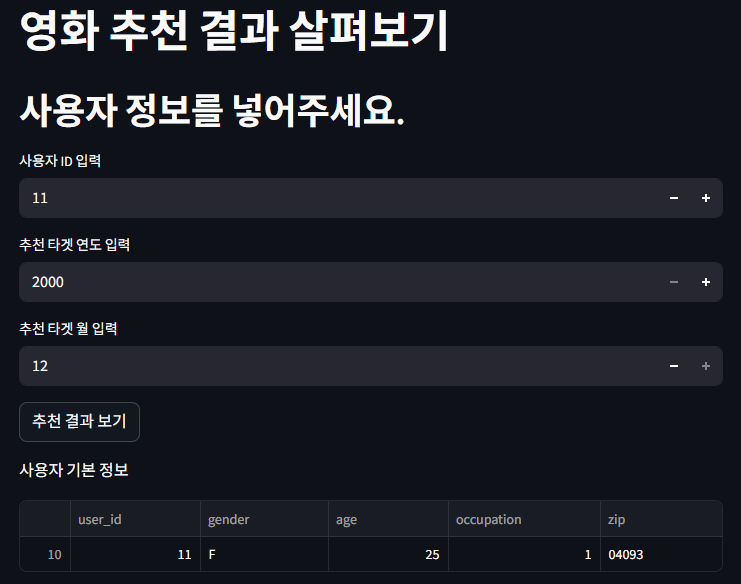
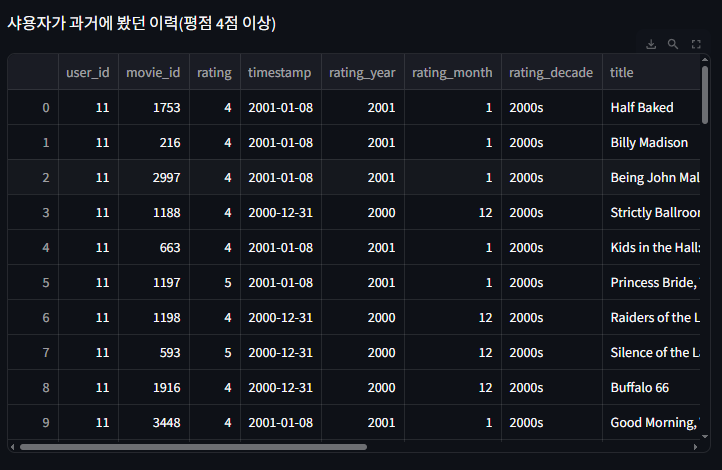